<a href="https://colab.research.google.com/github/kolinkovlad/titanic_survival_prediction/blob/main/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping




In [ ]:
train_data = pd.read_csv('/content/sample_data/train.csv')
X_train = train_data.drop(columns=["Survived"])
y_train = train_data["Survived"]

X_test = pd.read_csv('/content/sample_data/test.csv')





In [ ]:
# normalize X_train

numeric_cols = X_train.select_dtypes(include="number").columns
string_cols = X_train.select_dtypes(include="object").columns

# cleanup empty values from dfs
X_train[string_cols] = X_train[string_cols].fillna("unknown") # fill empty with "uknown" label
X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].mean())

# scale numeric + encode strings to numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('str', OneHotEncoder(drop='first',handle_unknown='ignore'), string_cols)
    ]
)

print(X_train.shape)
X_train_scaled = preprocessor.fit_transform(X_train).toarray() # fit_transform returned Matrix for some reason isntead of array
print(X_train_scaled.shape)


(891, 11)
(891, 1727)


In [ ]:
# normalize X_test
numeric_cols = X_test.select_dtypes(include="number").columns
string_cols = X_test.select_dtypes(include="object").columns

# cleanup empty values from dfs
X_test[string_cols] = X_test[string_cols].fillna("unknown") # fill empty with "uknown" label
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_test[numeric_cols].mean())

# scale numeric + encode strings to numeric (reuse X_train preprocessor)
X_test_scaled = preprocessor.transform(X_test).toarray() # fit_transform returned Matrix for some reason isntead of array
print(X_test_scaled.shape)



(418, 1727)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [197]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [198]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Stop after 10 epochs with no improvement
    restore_best_weights=True
)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [199]:
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5122 - loss: 0.7434 - val_accuracy: 0.7430 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7177 - loss: 0.6461 - val_accuracy: 0.7654 - val_loss: 0.6099 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7143 - loss: 0.6043 - val_accuracy: 0.7821 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7403 - loss: 0.5675 - val_accuracy: 0.7933 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7783 - loss: 0.5347 - val_accuracy: 0.8045 - val_loss: 0.5222 - learning_rate: 0.0010
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7898 - loss: 0.5305 - val_accuracy: 0.8268 - val_loss: 0.5091 - learning_rate: 0.0010
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8308 - loss: 0.4811 - val_ac

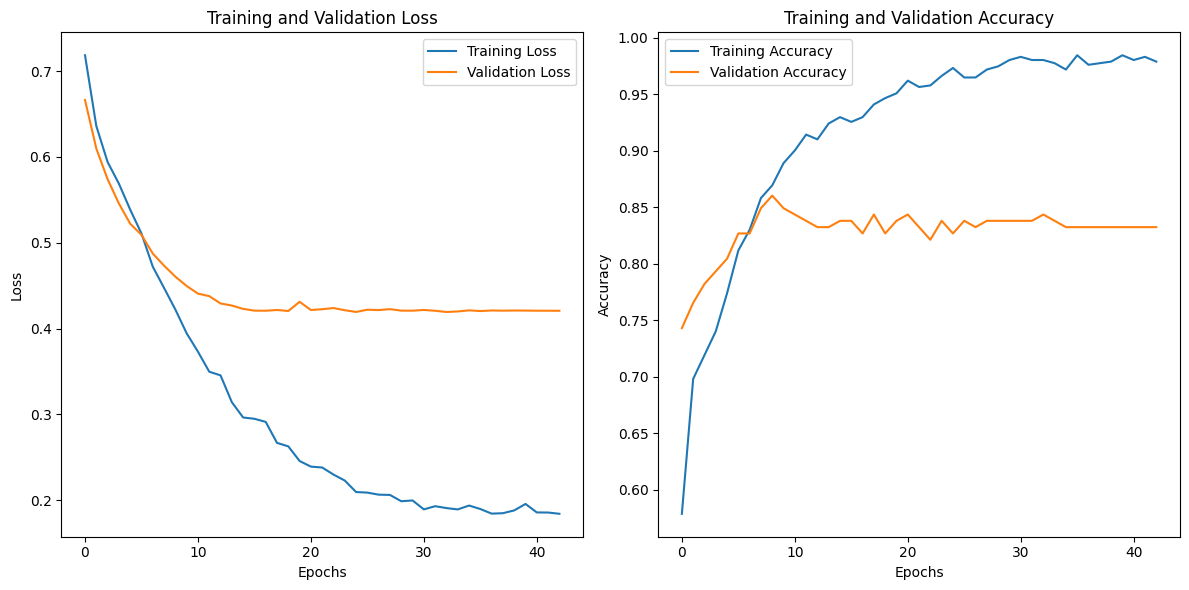

In [200]:
import matplotlib.pyplot as plt

# Extract loss and accuracy history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [201]:
y_pred = model.predict(X_test_scaled)

y_pred_class = (y_pred > 0.5).astype(int) # not sure if >0.5 is correct assumption
y_pred_df = pd.DataFrame(y_pred_class, columns=['Survived'])
result = pd.concat([X_test['PassengerId'], y_pred_df], axis=1)
print(result)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
